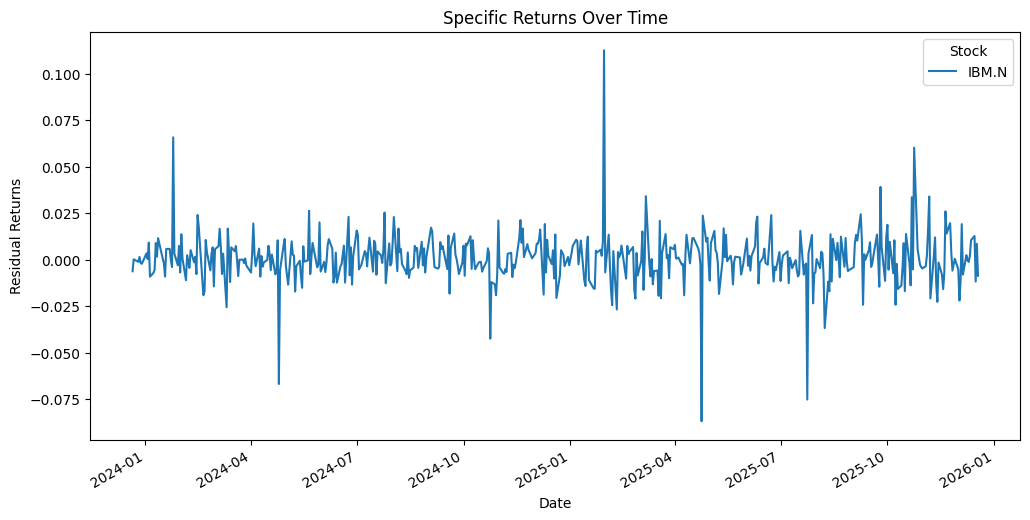

In [29]:
specific_returns['IBM.N'].plot(figsize=(12,6))
plt.title("Specific Returns Over Time")
plt.xlabel("Date")
plt.ylabel("Residual Returns")
plt.legend(title="Stock")
plt.show()

### Create Sample Portfolio

In [30]:
# Create an equal-weighted portfolio
n_stocks = len(common_stocks)
portfolio_weights = pd.Series(1/n_stocks, index=common_stocks)

print(f"Created equal-weighted portfolio with {n_stocks} stocks")
print(f"Weight per stock: {1/n_stocks:.4f}")

Created equal-weighted portfolio with 91 stocks
Weight per stock: 0.0110


### Calculate Portfolio Risk

In [31]:
# Calculate total portfolio risk
print("Calculating portfolio risk...")

# Get aligned data
w = portfolio_weights.values
X = exposures_aligned.values
F = factor_covariance.values
D = np.diag(specific_risk[common_stocks].values)

# Factor risk contribution
factor_risk = w.T @ X @ F @ X.T @ w

# Specific risk contribution
specific_risk_contrib = w.T @ D @ w

# Total risk
total_risk = np.sqrt(factor_risk + specific_risk_contrib)

print(f"\n{'='*50}")
print("PORTFOLIO RISK DECOMPOSITION")
print(f"{'='*50}")
print(f"Total Volatility:    {total_risk*100:.2f}%")
print(f"Factor Risk:         {np.sqrt(factor_risk)*100:.2f}% ({factor_risk/(factor_risk+specific_risk_contrib)*100:.1f}%)")
print(f"Specific Risk:       {np.sqrt(specific_risk_contrib)*100:.2f}% ({specific_risk_contrib/(factor_risk+specific_risk_contrib)*100:.1f}%)")
print(f"{'='*50}")

Calculating portfolio risk...

PORTFOLIO RISK DECOMPOSITION
Total Volatility:    13.70%
Factor Risk:         13.52% (97.4%)
Specific Risk:       2.21% (2.6%)


### Portfolio Factor Exposures

Portfolio Factor Exposures:
Size          0.036499
Volatility    0.012213
Quality       0.008003
Leverage      0.002936
Momentum      0.001817
Growth        0.001621
Value        -0.082449
dtype: object


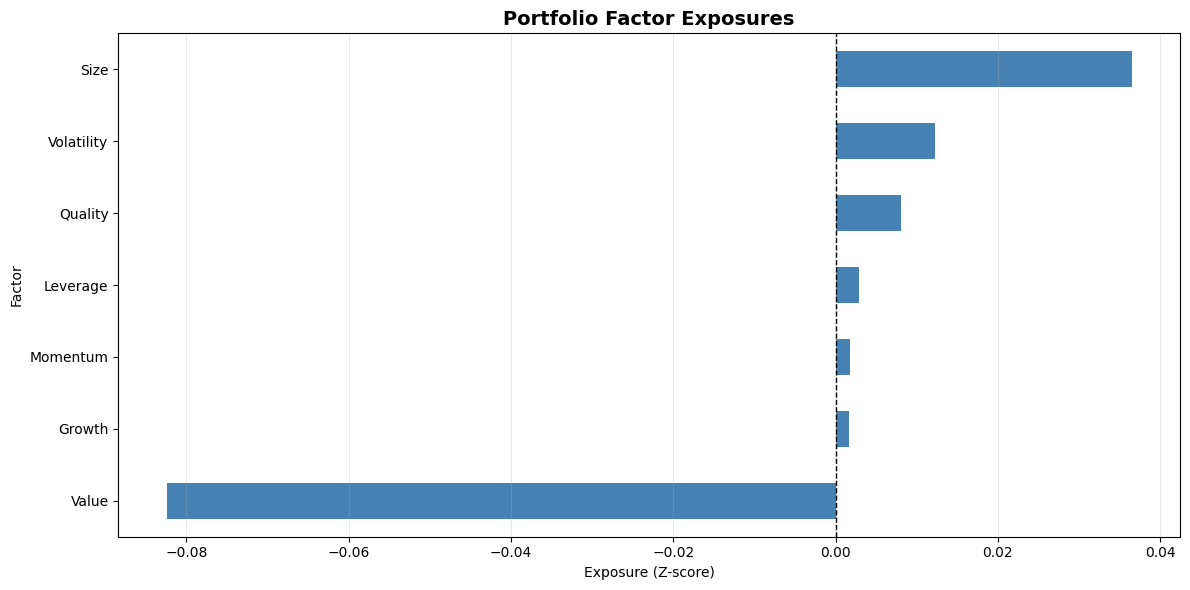

In [32]:
# Calculate portfolio factor exposures
portfolio_exposures = exposures_aligned.T @ portfolio_weights

print("Portfolio Factor Exposures:")
print(portfolio_exposures[style_factors].sort_values(ascending=False))

# Visualize
plt.figure(figsize=(12, 6))
portfolio_exposures[style_factors].sort_values().plot(kind='barh', color='steelblue')
plt.title('Portfolio Factor Exposures', fontsize=14, fontweight='bold')
plt.xlabel('Exposure (Z-score)')
plt.ylabel('Factor')
plt.axvline(x=0, color='black', linestyle='--', linewidth=1)
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

### Marginal Contribution to Risk (MCR) - TRUE BARRA METHOD

In [33]:
# Calculate MCR properly accounting for factor correlations
print("="*70)
print("MARGINAL CONTRIBUTION TO RISK (MCR)")
print("="*70)

print("\nCalculating MCR using full Barra methodology...")

# Get portfolio factor exposures
w = portfolio_weights.values
X = exposures_aligned.values
F = factor_covariance.values

# Portfolio factor exposures: β_p = X^T @ w
beta_p = exposures_aligned.T @ portfolio_weights

print(f"\nPortfolio exposures shape: {beta_p.shape}")

# Factor contribution to portfolio variance: (Σ_f @ β_p)
# This is the covariance-weighted exposure
factor_variance_contribution = factor_covariance @ beta_p

print(f"Factor variance contribution shape: {factor_variance_contribution.shape}")

# Marginal Contribution to Risk (MCR) for each factor k:
# MCR_k = β_p,k * (Σ_f @ β_p)_k
# This accounts for correlation between factors!
mcr = beta_p * factor_variance_contribution

print(f"\nMCR shape: {mcr.shape}")

# Total factor risk (portfolio variance from factors)
# σ²_p,factors = β_p^T @ Σ_f @ β_p
factor_variance = beta_p.T @ factor_covariance @ beta_p
factor_risk = np.sqrt(factor_variance)

print(f"\nTotal factor risk (volatility): {factor_risk*100:.2f}%")

# Percentage contribution to total factor risk
# %CR_k = MCR_k / σ²_p,factors
pcr = (mcr / factor_variance) * 100

# Create results DataFrame
risk_decomp = pd.DataFrame({
    'Exposure': beta_p,
    'MCR': mcr,
    'Percent_Contribution': pcr
})

# Sort by absolute contribution
risk_decomp['Abs_Contribution'] = risk_decomp['Percent_Contribution'].abs()
risk_decomp = risk_decomp.sort_values('Abs_Contribution', ascending=False)

print("\n" + "="*70)
print("FACTOR RISK DECOMPOSITION")
print("="*70)

print("\nTop 15 Risk Contributors (accounting for correlations):")
print(risk_decomp[['Exposure', 'MCR', 'Percent_Contribution']].head(15))

print("\n" + "="*70)
print("STYLE FACTOR RISK BREAKDOWN")
print("="*70)

style_risk = risk_decomp.loc[risk_decomp.index.isin(style_factors)]
print("\nStyle Factors:")
print(style_risk[['Exposure', 'MCR', 'Percent_Contribution']])

print("\n" + "="*70)
print("INDUSTRY FACTOR RISK BREAKDOWN")  
print("="*70)

industry_factors = [col for col in risk_decomp.index if col.startswith('Sector_')]
if industry_factors:
    industry_risk = risk_decomp.loc[industry_factors]
    print(f"\nTop 10 Industry Contributors:")
    print(industry_risk[['Exposure', 'Percent_Contribution']].head(10))
    
    total_industry_contribution = industry_risk['Percent_Contribution'].sum()
    print(f"\nTotal Industry Contribution: {total_industry_contribution:.2f}%")

# Verify sum equals 100%
total_contribution = risk_decomp['Percent_Contribution'].sum()
print(f"\n" + "="*70)
print(f"VERIFICATION: Total contribution = {total_contribution:.2f}%")
print(f"(Should be ~100% accounting for rounding)")
print("="*70)

MARGINAL CONTRIBUTION TO RISK (MCR)

Calculating MCR using full Barra methodology...

Portfolio exposures shape: (18,)
Factor variance contribution shape: (18,)

MCR shape: (18,)

Total factor risk (volatility): 13.52%

FACTOR RISK DECOMPOSITION

Top 15 Risk Contributors (accounting for correlations):
                               Exposure       MCR Percent_Contribution
Sector_Information Technology  0.186813   0.00357            19.523761
Sector_Industrials             0.153846  0.003177            17.373637
Sector_Health Care             0.153846  0.002584              14.1295
Sector_Financials              0.098901  0.002457            13.436685
Sector_Consumer Discretionary  0.098901  0.001916            10.478923
Sector_Communication Services  0.098901  0.001589              8.68726
Sector_Consumer Staples         0.10989  0.001381             7.553032
Sector_Energy                  0.032967  0.000588             3.216134
Sector_Utilities               0.032967  0.000382         

### Visualize Risk Decomposition


Creating risk decomposition visualizations...


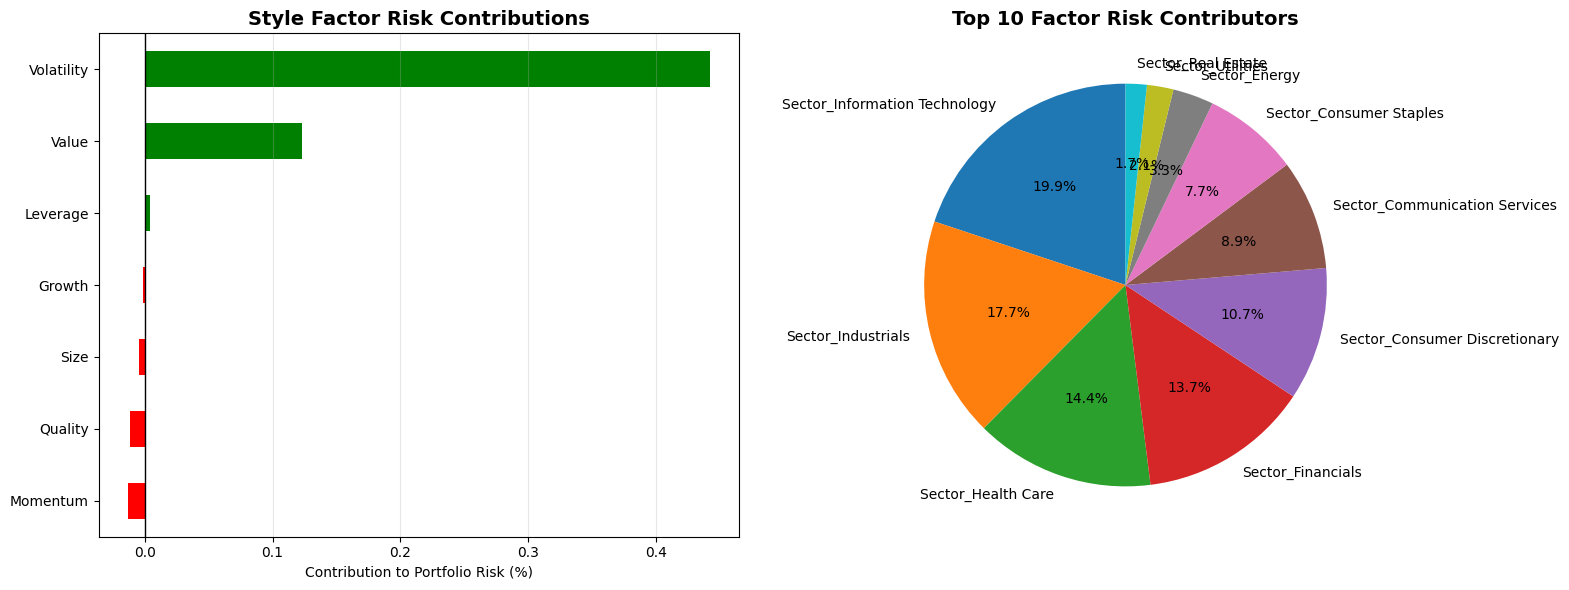

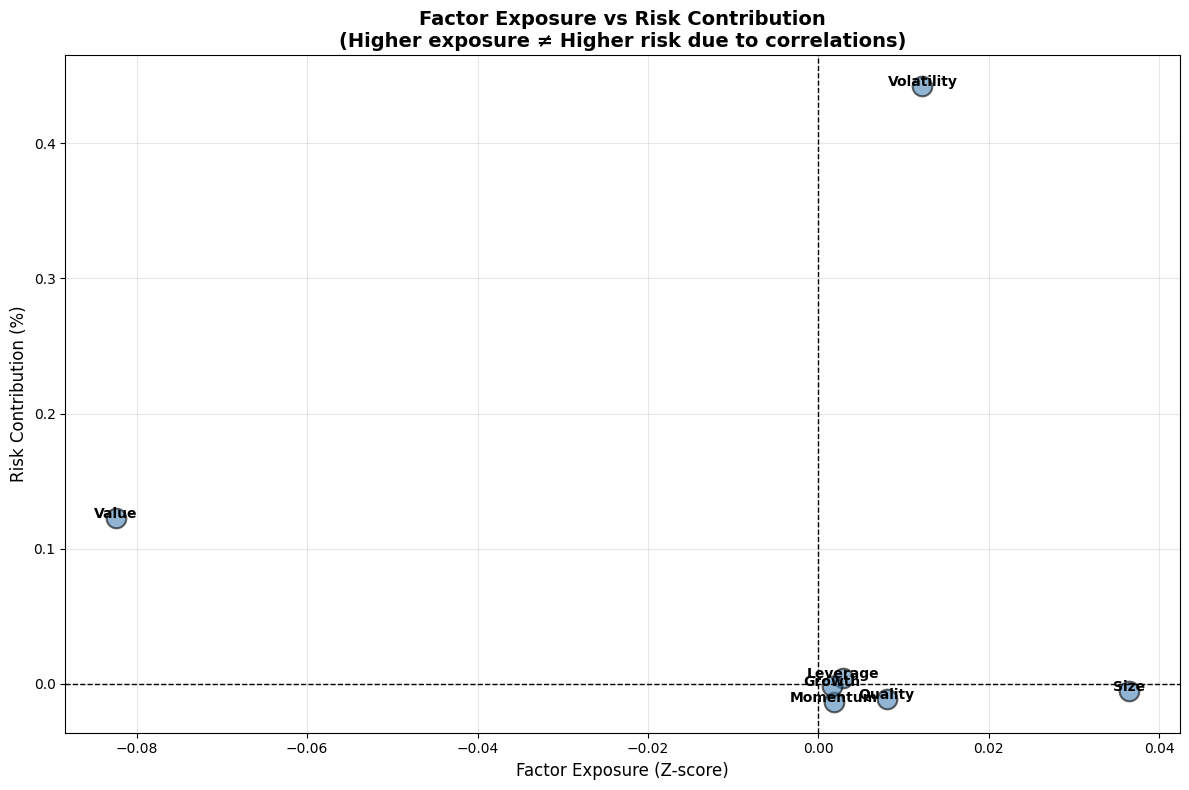


✓ Risk decomposition visualizations complete!


In [35]:
# Visualize risk contributions
print("\nCreating risk decomposition visualizations...")

# 1. Style factor contributions
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Bar chart of style factor contributions
style_risk_sorted = style_risk.sort_values('Percent_Contribution')
ax1 = axes[0]
colors = ['red' if x < 0 else 'green' for x in style_risk_sorted['Percent_Contribution']]
style_risk_sorted['Percent_Contribution'].plot(kind='barh', ax=ax1, color=colors)
ax1.set_title('Style Factor Risk Contributions', fontsize=14, fontweight='bold')
ax1.set_xlabel('Contribution to Portfolio Risk (%)')
ax1.axvline(x=0, color='black', linewidth=1)
ax1.grid(True, alpha=0.3, axis='x')

# Pie chart of absolute contributions (top 10)
ax2 = axes[1]
top_10_risk = risk_decomp.head(10).copy()
top_10_risk['Abs_Pct'] = top_10_risk['Percent_Contribution'].abs()
ax2.pie(top_10_risk['Abs_Pct'], labels=top_10_risk.index, autopct='%1.1f%%', startangle=90)
ax2.set_title('Top 10 Factor Risk Contributors', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

# 2. Exposure vs Risk Contribution scatter
plt.figure(figsize=(12, 8))
plt.scatter(style_risk['Exposure'], style_risk['Percent_Contribution'], 
            s=200, alpha=0.6, c='steelblue', edgecolors='black', linewidth=1.5)

for idx, row in style_risk.iterrows():
    plt.annotate(idx, (row['Exposure'], row['Percent_Contribution']),
                fontsize=10, fontweight='bold', ha='center')

plt.axhline(y=0, color='black', linestyle='--', linewidth=1)
plt.axvline(x=0, color='black', linestyle='--', linewidth=1)
plt.xlabel('Factor Exposure (Z-score)', fontsize=12)
plt.ylabel('Risk Contribution (%)', fontsize=12)
plt.title('Factor Exposure vs Risk Contribution\n(Higher exposure ≠ Higher risk due to correlations)', 
          fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\n✓ Risk decomposition visualizations complete!")

### Validate Against Barra (Comparison)

In [36]:
# Compare your calculated factors with industry benchmarks
print("="*70)
print("VALIDATION: COMPARE WITH BARRA-STYLE BENCHMARKS")
print("="*70)

print("""
To validate your model against actual Barra factors, you should check:

1. FACTOR VOLATILITIES
   - Your calculated factor vols vs typical Barra ranges
   - Style factors typically: 5-15% annualized
   - Industry factors typically: 10-25% annualized

2. FACTOR CORRELATIONS
   - Value vs Growth: typically negative (-0.3 to -0.6)
   - Momentum vs Value: typically negative
   - Size vs Volatility: typically negative

3. PORTFOLIO RISK DECOMPOSITION
   - Factor risk typically: 60-80% of total risk
   - Specific risk typically: 20-40% of total risk

Let's check your model:
""")

print("\n" + "="*70)
print("1. YOUR FACTOR VOLATILITIES")
print("="*70)

factor_vols_pct = np.sqrt(np.diag(factor_covariance)) * 100
vol_df = pd.DataFrame({
    'Factor': factor_covariance.index,
    'Volatility_Pct': factor_vols_pct
})

style_vols = vol_df[vol_df['Factor'].isin(style_factors)].set_index('Factor')
print("\nStyle Factor Volatilities (%):")
print(style_vols.sort_values('Volatility_Pct', ascending=False))

# Typical Barra ranges
typical_ranges = {
    'Value': (8, 12),
    'Growth': (8, 12),
    'Momentum': (10, 15),
    'Size': (6, 10),
    'Volatility': (12, 18),
    'Quality': (8, 12),
    'Leverage': (10, 15)
}

print("\nComparison with typical Barra ranges:")
for factor in style_factors:
    if factor in style_vols.index and factor in typical_ranges:
        vol = style_vols.loc[factor, 'Volatility_Pct']
        low, high = typical_ranges[factor]
        status = "✓" if low <= vol <= high else "⚠"
        print(f"{status} {factor:12s}: {vol:6.2f}%  (typical: {low}-{high}%)")

print("\n" + "="*70)
print("2. KEY FACTOR CORRELATIONS")
print("="*70)

# Convert covariance to correlation
factor_std = np.sqrt(np.diag(factor_covariance))
factor_corr = factor_covariance.values / np.outer(factor_std, factor_std)
factor_corr_df = pd.DataFrame(factor_corr, 
                               index=factor_covariance.index, 
                               columns=factor_covariance.columns)

# Key correlations to check
key_pairs = [
    ('Value', 'Growth', -0.45, 'negative'),
    ('Momentum', 'Value', -0.20, 'negative'),
    ('Size', 'Volatility', -0.30, 'negative'),
    ('Quality', 'Leverage', -0.25, 'negative')
]

print("\nKey correlation checks (vs typical Barra patterns):")
for f1, f2, typical, expected in key_pairs:
    if f1 in factor_corr_df.index and f2 in factor_corr_df.columns:
        corr = factor_corr_df.loc[f1, f2]
        status = "✓" if (expected == 'negative' and corr < 0) or (expected == 'positive' and corr > 0) else "⚠"
        print(f"{status} {f1:12s} vs {f2:12s}: {corr:6.3f}  (typical: ~{typical}, {expected})")

print("\n" + "="*70)
print("3. PORTFOLIO RISK ATTRIBUTION")
print("="*70)

# Already calculated earlier
print(f"\nYour Portfolio:")
print(f"  Total Risk:      {total_risk*100:.2f}%")
print(f"  Factor Risk:     {np.sqrt(factor_risk)*100:.2f}%  ({factor_risk/(factor_risk+specific_risk_contrib)*100:.1f}%)")
print(f"  Specific Risk:   {np.sqrt(specific_risk_contrib)*100:.2f}%  ({specific_risk_contrib/(factor_risk+specific_risk_contrib)*100:.1f}%)")

print(f"\nTypical Barra Model:")
print(f"  Factor Risk:     60-80% of total")
print(f"  Specific Risk:   20-40% of total")

factor_pct = factor_risk/(factor_risk+specific_risk_contrib)*100
if 60 <= factor_pct <= 80:
    print(f"\n✓ Your model's risk decomposition is within typical Barra ranges!")
else:
    print(f"\n⚠ Your factor/specific split differs from typical Barra models")
    print(f"   This could be due to portfolio concentration or factor definition differences")

print("\n" + "="*70)
print("VALIDATION SUMMARY")
print("="*70)
print("""
Your Barra-style risk model is complete! 


""")

VALIDATION: COMPARE WITH BARRA-STYLE BENCHMARKS

To validate your model against actual Barra factors, you should check:

1. FACTOR VOLATILITIES
   - Your calculated factor vols vs typical Barra ranges
   - Style factors typically: 5-15% annualized
   - Industry factors typically: 10-25% annualized

2. FACTOR CORRELATIONS
   - Value vs Growth: typically negative (-0.3 to -0.6)
   - Momentum vs Value: typically negative
   - Size vs Volatility: typically negative

3. PORTFOLIO RISK DECOMPOSITION
   - Factor risk typically: 60-80% of total risk
   - Specific risk typically: 20-40% of total risk

Let's check your model:


1. YOUR FACTOR VOLATILITIES

Style Factor Volatilities (%):
            Volatility_Pct
Factor                    
Volatility        8.995391
Size              5.428035
Value             5.404982
Momentum          5.361568
Growth            5.296350
Quality           4.720908
Leverage          2.578583

Comparison with typical Barra ranges:
⚠ Value       :   5.40%  (typica


=== Validating Volatility factor ===


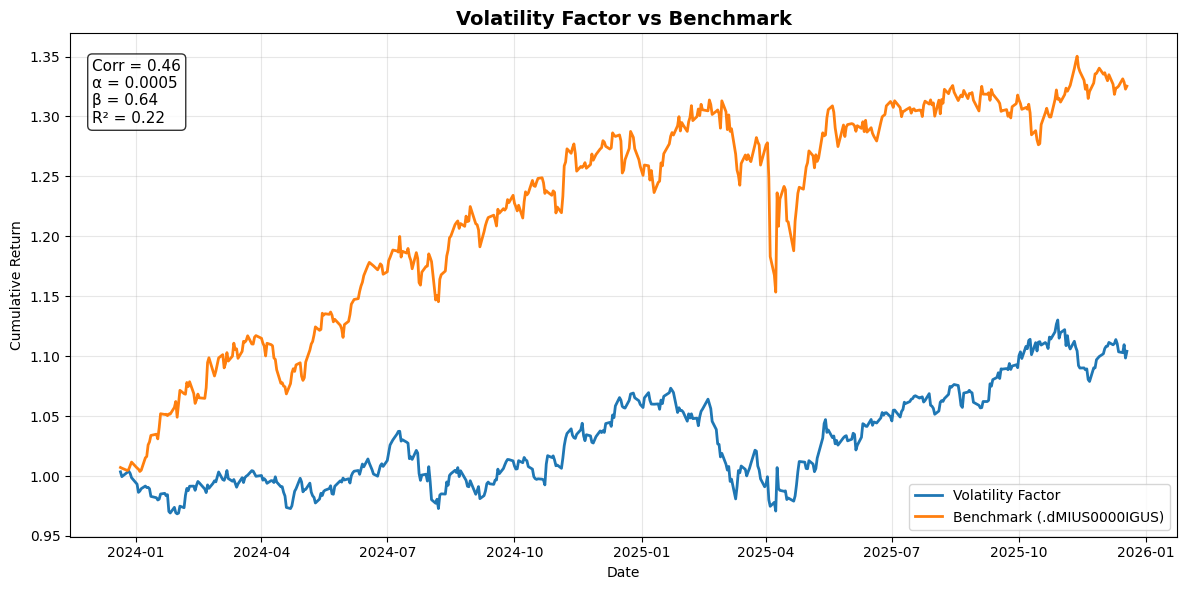

Correlation: 0.464, α = 0.0005, β = 0.636, R² = 0.216


,correlation,alpha,beta,r2
Volatility,0.46434,0.000457,0.635575,0.215612


In [69]:

import statsmodels.api as sm

# -----------------------------
# Map factor -> benchmark
# -----------------------------
FACTOR_BENCHMARK_MAP = {
    
    "Volatility": ".dMIUS0000IGUS",  # MSCI USA Low Vol (your current one)
   
}

# -----------------------------
# Core function
# -----------------------------
def validate_factor(
    factor_name,
    factor_returns,
    cumulative_returns,
    benchmark_universe,
    ld,
    start_date,
    end_date
):
    print(f"\n=== Validating {factor_name} factor ===")

    # --- Fetch benchmark prices ---
    benchmark_prices = ld.get_history(
        universe=benchmark_universe,
        fields="TR.PriceClose",
        interval="daily",
        start=start_date.strftime("%Y-%m-%d"),
        end=end_date.strftime("%Y-%m-%d")
    )

    benchmark_prices = benchmark_prices.squeeze()
    benchmark_returns = benchmark_prices.pct_change().dropna()
    benchmark_cum = (1 + benchmark_returns).cumprod()

    # --- Factor returns ---
    factor_ret = factor_returns[factor_name].dropna()
    factor_cum = cumulative_returns[factor_name].dropna()

    # --- Align dates ---
    aligned = pd.concat([factor_ret, benchmark_returns], axis=1, join='inner').dropna()
    aligned.columns = ["Factor", "Benchmark"]

    # --- Correlation ---
    corr = aligned["Factor"].corr(aligned["Benchmark"])

    # --- Regression ---
    X = sm.add_constant(aligned["Factor"])
    y = aligned["Benchmark"]
    model = sm.OLS(y, X).fit()
    alpha = model.params["const"]
    beta = model.params["Factor"]
    r2 = model.rsquared

    # --- Align cumulative series for plotting ---
    factor_cum_plot = factor_cum.loc[aligned.index]
    benchmark_cum_plot = benchmark_cum.loc[aligned.index]

    # --- Plot ---
    plt.figure(figsize=(12, 6))
    plt.plot(factor_cum_plot.index, factor_cum_plot, label=f"{factor_name} Factor", linewidth=2)
    plt.plot(benchmark_cum_plot.index, benchmark_cum_plot, label=f"Benchmark ({benchmark_universe})", linewidth=2)

    textstr = f"Corr = {corr:.2f}\nα = {alpha:.4f}\nβ = {beta:.2f}\nR² = {r2:.2f}"
    plt.title(f"{factor_name} Factor vs Benchmark", fontsize=14, fontweight="bold")
    plt.xlabel("Date")
    plt.ylabel("Cumulative Return")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.gca().text(0.02, 0.95, textstr, transform=plt.gca().transAxes,
                   fontsize=11, verticalalignment="top",
                   bbox=dict(boxstyle="round", facecolor="white", alpha=0.8))
    plt.tight_layout()
    plt.show()

    print(f"Correlation: {corr:.3f}, α = {alpha:.4f}, β = {beta:.3f}, R² = {r2:.3f}")

    return {
        "correlation": corr,
        "alpha": alpha,
        "beta": beta,
        "r2": r2
    }


# -----------------------------
# Loop over all available factors
# -----------------------------
results = {}
for factor in FACTOR_BENCHMARK_MAP.keys():
    results[factor] = validate_factor(
        factor_name=factor,
        factor_returns=factor_returns,
        cumulative_returns=cumulative_returns,
        benchmark_universe=FACTOR_BENCHMARK_MAP[factor],
        ld=ld,
        start_date=start_date,
        end_date=end_date
    )

# Convert to DataFrame
results_df = pd.DataFrame(results).T
results_df


In [37]:
# Close LSEG session
ld.close_session()
print("LSEG session closed")

LSEG session closed
